# Dutch Corpora

In [156]:
# Install tempo-embeddings from GitHub
# This can also refer to a specific version or branch

%pip install --upgrade pip  # Required for properly resolving dependencies
%pip uninstall -y tempo_embeddings  # Remove existing installation
%pip install --upgrade git+https://github.com/Semantics-of-Sustainability/tempo-embeddings.git

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [157]:
# make sure installation has succeeded
import tempo_embeddings

In [158]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [159]:
try:
    import google.colab

    IN_COLAB = True
except ModuleNotFoundError:
    IN_COLAB = False

## Load Model

In [160]:
%autoreload now

LAYER = 9

from tempo_embeddings.embeddings.model import (
    RobertaModelWrapper,
    TransformerModelWrapper,
    XModModelWrapper,
    SentenceTransformerModelWrapper,
)

kwargs = {"accelerate": True}

### RoBERTa Models
# MODEL_NAME = "DTAI-KULeuven/robbertje-1-gb-non-shuffled"
# model_class = RobertaModelWrapper

### XMod Models
# MODEL_NAME = "facebook/xmod-base"
# kwargs["default_language"] = "nl_XX"
# model_class = XModModelWrapper

### BERT Models
# MODEL_NAME = "GroNLP/bert-base-dutch-cased"
# MODEL_NAME = "xlm-roberta-base"
# MODEL_NAME = "xlm-mlm-100-1280"
# model_class = TransformerModelWrapper

### Sentence Transformers
MODEL_NAME = "NetherlandsForensicInstitute/robbert-2022-dutch-sentence-transformers"
# MODEL_NAME = "textgain/allnli-GroNLP-bert-base-dutch-cased"
model_class = SentenceTransformerModelWrapper

In [161]:
model = model_class.from_pretrained(MODEL_NAME, layer=LAYER, **kwargs)
model

## Load Data

The data needs to be downloaded and provided in the path configured in the next cell.

NOTE: You have to manually adapt the `DATA_DIR` below.

In [162]:
%autoreload now

import operator
from functools import reduce
from pathlib import Path
from tqdm import tqdm
from tempo_embeddings.text.corpus import Corpus

In [163]:
WINDOW_SIZE = 200

RANDOM_SAMPLE_ANP = 200
RANDOM_SAMPLE_STATEN_GENERAAL = 200

STATEN_GENERAAL_BLACKLIST = ["1987"]

FILTER_TERMS = ["duurzaam"]  # Search term(s) for filtering the corpus

In [164]:
### NOTE: Adapt the `DATA_DIR` below manually!
### For a shared Google Drive, create a shortcut into your own Google Drive
### See https://stackoverflow.com/questions/54351852/accessing-shared-with-me-with-colab

LOCAL_PATHS: list[Path] = [
    Path.home() / "Documents" / "SemanticsOfSustainability" / "data" / "Joris",
    Path("/data/volume_2/data"),  # Research Cloud
    Path("/home/cschnober/data/"),  # Snellius
]

if IN_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")

    DATA_DIR = Path("/content/drive/MyDrive/Data/")
else:
    try:
        DATA_DIR = next(path for path in LOCAL_PATHS if path.is_dir())
    except StopIteration as e:
        raise DirectoryNotFoundError(f"Data directory not found.") from e

assert DATA_DIR.is_dir(), f"Data dir '{DATA_DIR}' not found."

### ANP

In [165]:
ANP_DIR = DATA_DIR / "ANP"
assert RANDOM_SAMPLE_ANP == 0 or ANP_DIR.is_dir(), f"{ANP_DIR} not found."

In [166]:
import random

random.seed(0)

anp_files = list(ANP_DIR.glob("ANP_????.csv.gz"))

if RANDOM_SAMPLE_ANP and len(anp_files) > RANDOM_SAMPLE_ANP:
    anp_files = random.sample(
        list(ANP_DIR.glob("ANP_????.csv.gz")), k=RANDOM_SAMPLE_ANP
    )
anp_files[:10]

[]

In [167]:
anp_corpus = (
    reduce(
        operator.add,
        (
            Corpus.from_csv_file(
                path,
                filter_terms=FILTER_TERMS,
                text_columns=["content"],
                encoding="iso8859_15",
                compression="gzip",
                delimiter=";",
                window_size=WINDOW_SIZE,
            )
            for path in tqdm(anp_files, unit="file")
        ),
    )
    if anp_files
    else Corpus()
)

len(anp_corpus)

0

### Staten Generaal

In [168]:
STATEN_GENERAAL_DIR = DATA_DIR / "StatenGeneraal"

assert RANDOM_SAMPLE_STATEN_GENERAAL == 0 or STATEN_GENERAAL_DIR.is_dir()

In [169]:
glob195x = "StatenGeneraal_19[0-9]?.csv.gz"  # Pattern for files from 1950-1999
glob20xx = "StatenGeneraal_2???.csv.gz"  # Pattern for files from 2000

files_195x = list(STATEN_GENERAAL_DIR.glob(glob195x))
files_20xx = list(STATEN_GENERAAL_DIR.glob(glob20xx))

sg_files = [
    file
    # Merge files from patterns
    for file in files_20xx + files_195x
    # Remove blacklisted files:
    for blacklisted in STATEN_GENERAAL_BLACKLIST
    if blacklisted not in file.name
]

if RANDOM_SAMPLE_STATEN_GENERAAL and RANDOM_SAMPLE_STATEN_GENERAAL < len(sg_files):
    sg_files = random.sample(sg_files, k=RANDOM_SAMPLE_STATEN_GENERAAL)

sorted(sg_files)

[PosixPath('/Users/carstenschnober/Documents/SemanticsOfSustainability/data/Joris/StatenGeneraal/StatenGeneraal_1900.csv.gz'),
 PosixPath('/Users/carstenschnober/Documents/SemanticsOfSustainability/data/Joris/StatenGeneraal/StatenGeneraal_1902.csv.gz'),
 PosixPath('/Users/carstenschnober/Documents/SemanticsOfSustainability/data/Joris/StatenGeneraal/StatenGeneraal_1911.csv.gz'),
 PosixPath('/Users/carstenschnober/Documents/SemanticsOfSustainability/data/Joris/StatenGeneraal/StatenGeneraal_1925.csv.gz'),
 PosixPath('/Users/carstenschnober/Documents/SemanticsOfSustainability/data/Joris/StatenGeneraal/StatenGeneraal_1934.csv.gz'),
 PosixPath('/Users/carstenschnober/Documents/SemanticsOfSustainability/data/Joris/StatenGeneraal/StatenGeneraal_1936.csv.gz'),
 PosixPath('/Users/carstenschnober/Documents/SemanticsOfSustainability/data/Joris/StatenGeneraal/StatenGeneraal_1938.csv.gz'),
 PosixPath('/Users/carstenschnober/Documents/SemanticsOfSustainability/data/Joris/StatenGeneraal/StatenGeneraal

In [170]:
%autoreload now

import csv

csv.field_size_limit(100000000)

sg_corpus = (
    reduce(
        operator.add,
        (
            Corpus.from_csv_file(
                path,
                filter_terms=FILTER_TERMS,
                text_columns=["Content"],
                encoding="utf-8",
                compression="gzip",
                delimiter=";",
                window_size=WINDOW_SIZE,
            )
            for path in tqdm(sg_files, unit="file")
        ),
    )
    if sg_files
    else Corpus()
)

len(sg_corpus)

  0%|          | 0/20 [00:00<?, ?file/s]

100%|██████████| 20/20 [00:08<00:00,  2.32file/s]


2959

In [171]:
for p in sg_corpus.passages[:20]:
    print(len(p), p)

202 Passage('maar ik bedoel hiermede het vertrouwen uit te spreken dat de wetsvoorstellen welke van dit Kabinet zullen uitgaan, de bestuursmaatregelen door deze Regeering te nemen , mogen blijken te zijn duurzaam en', {'': '2', 'date': '1902-01-28', 'title': 'Handelingen Eerste Kamer 1901-1902 28 januari 1902, Paginas 123-140.', 'RecId': 'nl.proc.sgd.d.190119020000110', 'type': 'Verbatim Proceedings', 'leg_period': '1901-1902', 'chamber': 'EersteKamer', 'speakers': 'nl.m.00462: mp, De heer: Gleichman; nl.m.01404: mp, De heer: van Velzen jr.; : mp, De heer: van (Ion BieMD; nl.m.01148: mp, De heer: Rutgers van Rozenburg; nl.m.00610: mp, De heer: Hovy; : mp, De heer: Uesrout; : mp, De heer: van Weideren Kengers; nl.m.00965: mp, De heer: van Nierop; nl.m.00014: mp, De heer: Alberda van Ekenstein; : mp, De heer: Jirechaart; nl.m.00421: mp, De heer: Fransen van de Putte', 'year': '1902'}, Highlighting(start=191, end=199))
202 Passage('door iemand die goed praten kan , maar als het er op aank

### Merge

In [172]:
corpus = anp_corpus + sg_corpus
len(corpus)

2959

## Compute Embeddings

In [173]:
%autoreload now

from tempo_embeddings.embeddings.model import EmbeddingsMethod

model.batch_size = 128
model.embeddings_method = EmbeddingsMethod.MEAN

corpus.embeddings = model.compute_embeddings(corpus)

Embeddings:   0%|          | 0/24 [00:00<?, ?batch/s]

Embeddings: 100%|██████████| 24/24 [00:13<00:00,  1.77batch/s]


UMAP( verbose=True)
Fri Dec 15 13:55:00 2023 Construct fuzzy simplicial set
Fri Dec 15 13:55:04 2023 Finding Nearest Neighbors
Fri Dec 15 13:55:04 2023 Finished Nearest Neighbor Search
Fri Dec 15 13:55:04 2023 Construct embedding


Epochs completed:   9%| ▊          43/500 [00:01]

	completed  0  /  500 epochs
	completed  50  /  500 epochs


Epochs completed:  45%| ████▍      224/500 [00:01]

	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs


Epochs completed:  71%| ███████    353/500 [00:01]

	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs


Epochs completed: 100%| ██████████ 500/500 [00:01]

	completed  400  /  500 epochs
	completed  450  /  500 epochs
Fri Dec 15 13:55:05 2023 Finished embedding


## Read Stopwords

In [174]:
!wget --continue https://raw.githubusercontent.com/Semantics-of-Sustainability/tempo-embeddings/main/tempo_embeddings/data/stopwords-filter-nl.txt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
--2023-12-15 13:55:06--  https://raw.githubusercontent.com/Semantics-of-Sustainability/tempo-embeddings/main/tempo_embeddings/data/stopwords-filter-nl.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [175]:
stopwords_file = Path("stopwords-filter-nl.txt")

with open(stopwords_file.absolute(), "rt") as f:
    stopwords = set(f.read().splitlines())

stopwords.update(
    {
        "wij",
        "we",
        "moeten",
        "heer",
        "mevrouw",
        "minister",
        "voorzitter",
        "gaat",
        "wel",
        "den",
    }
)

## Cluster

In [176]:
%autoreload now

# Arguments: min_cluster_size=10, cluster_selection_epsilon=0.1, ...
# See https://scikit-learn.org/stable/modules/generated/sklearn.cluster.HDBSCAN.html for full list

# e.g. min_samples=10, cluster_selection_epsilon=0.2, cluster_selection_method="leaf"

clusters = corpus.cluster(min_cluster_size=10, cluster_selection_epsilon=0.1)
print(clusters)

[Subcorpus(0, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), Subcorpus(1, [427, 428, 429, 430, 431, 432, 499, 555, 556, 557]), Subcorpus(-1, [1409, 1924, 1925, 1938, 1939, 1951, 1952, 2289, 2290, 2293])]


In [177]:
for cluster in clusters:
    cluster.set_topic_label(exclude_words=stopwords | set(FILTER_TERMS), n=5)
    print(cluster)

/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/tempo-embeddings/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Subcorpus('duurzaamheid; vraag; kabinet; bouwen; ten', [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Subcorpus('visserijbeleid; dierenwelzijn; gevangen; regering; verzoekt', [427, 428, 429, 430, 431, 432, 499, 555, 556, 557])
Subcorpus('Outliers', [1409, 1924, 1925, 1938, 1939, 1951, 1952, 2289, 2290, 2293])


# Visualize Embeddings

<Axes: xlabel='x', ylabel='y'>

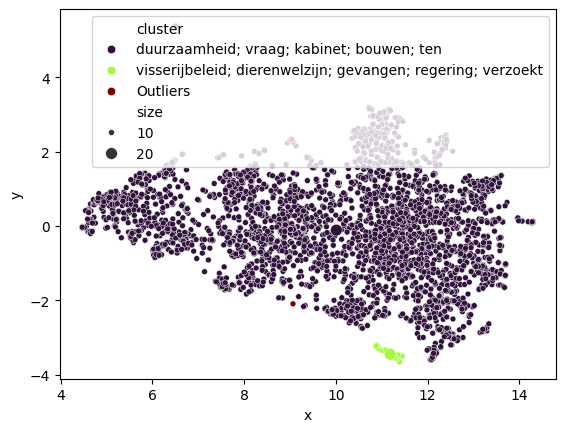

In [178]:
%autoreload now

from tempo_embeddings.visualization.clusters import ClusterVisualizer

visualizer = ClusterVisualizer(*clusters)
visualizer.visualize()

In [179]:
import os
from bokeh.io import output_notebook
from bokeh.io import reset_output
from bokeh.plotting import show
from tempo_embeddings.visualization.bokeh import BokehInteractiveVisualizer


output_notebook()
# reset_output()

visualizer = BokehInteractiveVisualizer(
    *clusters, metadata_fields=corpus.metadata_fields(), width=2000, height=1000
)

os.environ[
    "BOKEH_ALLOW_WS_ORIGIN"
] = "196g3qhrickgm9bpd0kgamlmid74eo61pes1eeu80dbm2djdbuos"

show(visualizer.create_document)

Loading BokehJS ...